In [1]:
from pyspark.sql import SparkSession

spark= SparkSession.builder\
    .appName('Gestion Logistique')\
    .master("local[*]")\
    .getOrCreate()

print(f"Spark session {spark.version}")

print("hello")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/19 09:52:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark session 3.5.1
hello


# Chargement des données

In [2]:
url="/workspace/data/raw/DataCoSupplyChainDataset.csv"
data=spark.read.csv(url,header=True,inferSchema=True)
print(f"nbre de ligne {data.count()}")

nbre de ligne 180519


In [3]:
data.printSchema()

root
 |-- Type: string (nullable = true)
 |-- Days for shipping (real): integer (nullable = true)
 |-- Days for shipment (scheduled): integer (nullable = true)
 |-- Benefit per order: double (nullable = true)
 |-- Sales per customer: double (nullable = true)
 |-- Delivery Status: string (nullable = true)
 |-- Late_delivery_risk: integer (nullable = true)
 |-- Category Id: integer (nullable = true)
 |-- Category Name: string (nullable = true)
 |-- Customer City: string (nullable = true)
 |-- Customer Country: string (nullable = true)
 |-- Customer Email: string (nullable = true)
 |-- Customer Fname: string (nullable = true)
 |-- Customer Id: integer (nullable = true)
 |-- Customer Lname: string (nullable = true)
 |-- Customer Password: string (nullable = true)
 |-- Customer Segment: string (nullable = true)
 |-- Customer State: string (nullable = true)
 |-- Customer Street: string (nullable = true)
 |-- Customer Zipcode: integer (nullable = true)
 |-- Department Id: integer (nullable = 

In [4]:
data.show(5)

25/11/19 09:52:25 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+--------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+--------------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+-------------+---------------+-------------------+-------------------+--------------------+------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per c

In [5]:
data.dtypes

[('Type', 'string'),
 ('Days for shipping (real)', 'int'),
 ('Days for shipment (scheduled)', 'int'),
 ('Benefit per order', 'double'),
 ('Sales per customer', 'double'),
 ('Delivery Status', 'string'),
 ('Late_delivery_risk', 'int'),
 ('Category Id', 'int'),
 ('Category Name', 'string'),
 ('Customer City', 'string'),
 ('Customer Country', 'string'),
 ('Customer Email', 'string'),
 ('Customer Fname', 'string'),
 ('Customer Id', 'int'),
 ('Customer Lname', 'string'),
 ('Customer Password', 'string'),
 ('Customer Segment', 'string'),
 ('Customer State', 'string'),
 ('Customer Street', 'string'),
 ('Customer Zipcode', 'int'),
 ('Department Id', 'int'),
 ('Department Name', 'string'),
 ('Latitude', 'double'),
 ('Longitude', 'double'),
 ('Market', 'string'),
 ('Order City', 'string'),
 ('Order Country', 'string'),
 ('Order Customer Id', 'int'),
 ('order date (DateOrders)', 'string'),
 ('Order Id', 'int'),
 ('Order Item Cardprod Id', 'int'),
 ('Order Item Discount', 'double'),
 ('Order Item 

In [6]:
from pyspark.sql import functions as F

data.groupBy("Late_delivery_risk").agg(F.sum(F.col("Sales per customer"))).show()

+------------------+-----------------------+
|Late_delivery_risk|sum(Sales per customer)|
+------------------+-----------------------+
|                 1|    1.808255529625551E7|
|                 0|   1.4971847083960945E7|
+------------------+-----------------------+



In [7]:
final_cols = ["Days for shipment (scheduled)" ,"Order State" ,"Order Region" ,"Sales" ,"Order Item Quantity" ,"Order Item Profit Ratio" , "Order Item Product Price","Order Item Discount Rate" ,"Order Item Discount" ,"Order Country" ,"Order City"  ,"Latitude" , "Longitude" , "Customer Segment" ,"Category Name" ,"Late_delivery_risk" ,"Delivery Status" ,"Sales per customer" ]
for col in final_cols:
    count_missing = data.filter((data[col].isNull())).count()
    if count_missing !=  0 :
        print(f"Column '{col}' → {count_missing} zero values")

len(final_cols)

25/11/19 09:52:31 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


18

# Analyse Exploratoire des Données (EDA)

        Affichage des duplicated apres les supprimer

In [8]:
from pyspark.sql import functions as F

duplicates=data.groupBy(data.columns).count().filter(F.col("count")>1)
print("Doublons detectes :")
duplicates.show(5)

Doublons detectes :


+----+------------------------+-----------------------------+-----------------+------------------+---------------+------------------+-----------+-------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+---------------+----------------+-------------+---------------+--------+---------+------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+-----+----------------+----------------------+------------+-----------+------------+-------------+---------------+-------------------+-------------------+-------------+------------+-------------+--------------+--------------------------+-------------+-----+
|Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|Delivery Status|Late_delivery_r

In [9]:
df=data.dropDuplicates()
print(f"Doublons suprimés. Nombre de lignes restantes : {df.count()}")

[Stage 70:=================================>                      (13 + 9) / 22]

Doublons suprimés. Nombre de lignes restantes : 180519


        Vérification et suppression des lignes entièrement nulles

In [10]:
data.describe().show()

[Stage 78:>                                                         (0 + 1) / 1]

+-------+--------+------------------------+-----------------------------+------------------+------------------+----------------+-------------------+------------------+------------------+-------------+----------------+--------------+--------------+-----------------+--------------+-----------------+----------------+------------------+---------------+-----------------+------------------+---------------+-----------------+------------------+------+--------------+-------------+-----------------+-----------------------+------------------+----------------------+-------------------+------------------------+-----------------+------------------------+-----------------------+-------------------+------------------+------------------+----------------------+--------------+--------------+---------------+------------------+------------------+-------------------+-------------------+--------------------+--------------------+-----------------+--------------+--------------------------+--------------+
|summ

# Gerer les valeurs manquantes

In [11]:
print("Nombre de valeurs nulles par colonne :")
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

Nombre de valeurs nulles par colonne :


[Stage 79:==>                                                     (1 + 21) / 22]

+----+------------------------+-----------------------------+-----------------+------------------+---------------+------------------+-----------+-------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+---------------+----------------+-------------+---------------+--------+---------+------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+-----+----------------+----------------------+------------+-----------+------------+-------------+---------------+-------------------+-------------------+-------------+------------+-------------+--------------+--------------------------+-------------+
|Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|Delivery Status|Late_delivery_risk|Ca

In [12]:
print("Nombre de valeurs egale a 0 par colonne :")
df.select([F.count(F.when(F.col(c) == 0, c)).alias(c) for c in df.columns]).show()



Nombre de valeurs egale a 0 par colonne :


[Stage 85:==>                                                     (1 + 21) / 22]

+----+------------------------+-----------------------------+-----------------+------------------+---------------+------------------+-----------+-------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+---------------+----------------+-------------+---------------+--------+---------+------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+-----+----------------+----------------------+------------+-----------+------------+-------------+---------------+-------------------+-------------------+-------------+------------+-------------+--------------+--------------------------+-------------+
|Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|Delivery Status|Late_delivery_risk|Ca

In [13]:
df.groupBy("Late_delivery_risk").count().show()

[Stage 91:==>                                                     (1 + 21) / 22]

+------------------+-----+
|Late_delivery_risk|count|
+------------------+-----+
|                 1|98977|
|                 0|81542|
+------------------+-----+



In [14]:
# Suppression des colonnes non utiles
columns_to_drop = [
    "Order Id", "Order Item Id", "Order Customer Id", "Customer Id",
    "Order Item Cardprod Id", "Product Card Id", "Product Category Id",
    "Department Id", "Category Id",
    
    "Customer Email", "Customer Fname", "Customer Lname", "Customer Password",
    "Customer Street", "Customer Zipcode",
    
    "Order Zipcode",
    
    "Product Description", "Product Image", "Product Name",
      
    "Type",              
    "Product Status",    
    "Order Status"       
]


df = df.drop(*columns_to_drop)
print(f" Supprimé {len(columns_to_drop)} non utiles colonnes.")

 Supprimé 22 non utiles colonnes.


In [15]:
df.show(5)

[Stage 97:==>                                                     (1 + 21) / 22]

+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+----------------+-------------+----------------+----------------+--------------+---------------+-----------+------------+------------+-------------+-------------+-----------------------+-------------------+------------------------+------------------------+-----------------------+-------------------+-----------+----------------+----------------------+---------------+------------+-------------+--------------------------+--------------+
|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer| Delivery Status|Late_delivery_risk|   Category Name|Customer City|Customer Country|Customer Segment|Customer State|Department Name|   Latitude|   Longitude|      Market|   Order City|Order Country|order date (DateOrders)|Order Item Discount|Order Item Discount Rate|Order Item Product Price|Order Item Profit Ratio|Order Item Quantity|    

In [16]:
len(df.dtypes)

31

In [17]:
df.show()

[Stage 100:==>                                                    (1 + 21) / 22]

+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+----------------+-------------+----------------+----------------+--------------+---------------+-----------+------------+------------+-------------+--------------+-----------------------+-------------------+------------------------+------------------------+-----------------------+-------------------+-----------+----------------+----------------------+---------------+--------------------+-------------+--------------------------+--------------+
|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|  Delivery Status|Late_delivery_risk|   Category Name|Customer City|Customer Country|Customer Segment|Customer State|Department Name|   Latitude|   Longitude|      Market|   Order City| Order Country|order date (DateOrders)|Order Item Discount|Order Item Discount Rate|Order Item Product Price|Order Item Profit Ratio|Order Item Q

In [18]:
numeric_COLUMN = [
    "Days for shipping (real)",
    "Days for shipment (scheduled)",
    "Benefit per order",
    "Sales",
    "Order Item Total",
    "Order Item Product Price",
    "Order Item Quantity",
    "Order Item Profit Ratio",
    "Order Profit Per Order",
    "Product Price",
    "Sales per customer" 
]


In [19]:
numeric_data = df.select(numeric_COLUMN)

numeric_data

DataFrame[Days for shipping (real): int, Days for shipment (scheduled): int, Benefit per order: double, Sales: double, Order Item Total: double, Order Item Product Price: double, Order Item Quantity: int, Order Item Profit Ratio: double, Order Profit Per Order: double, Product Price: double, Sales per customer: double]

In [20]:
spark_to_pd = numeric_data.toPandas()


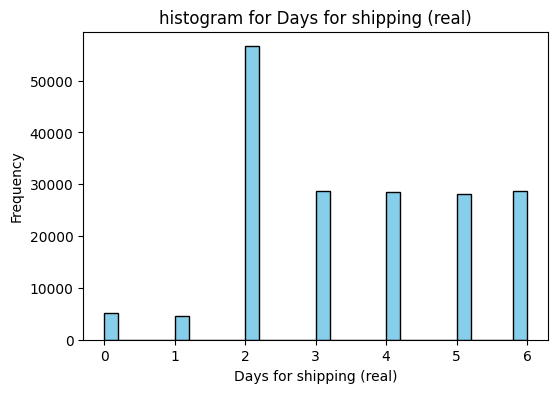

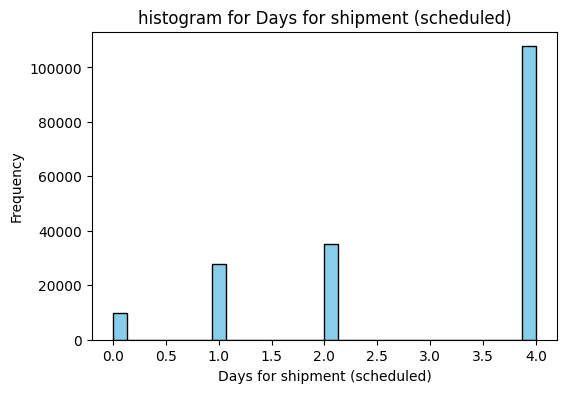

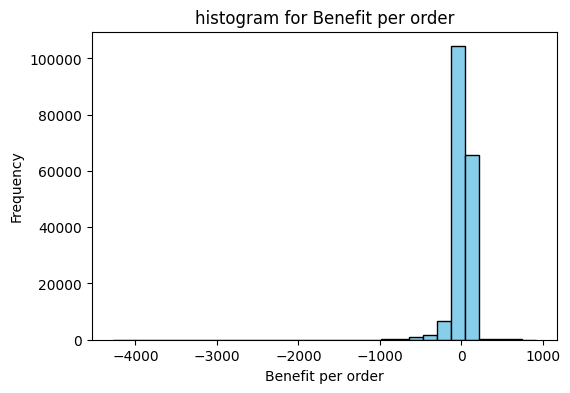

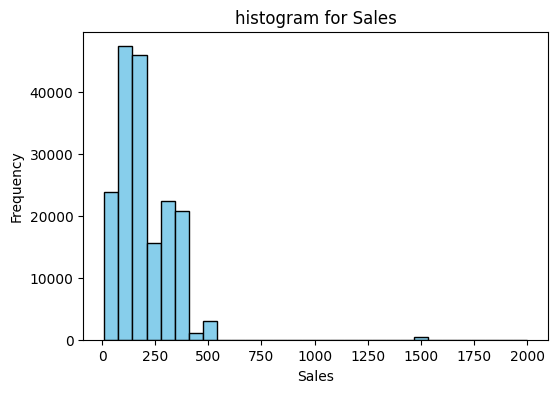

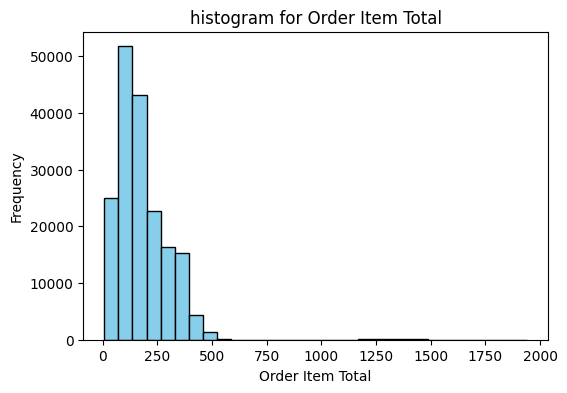

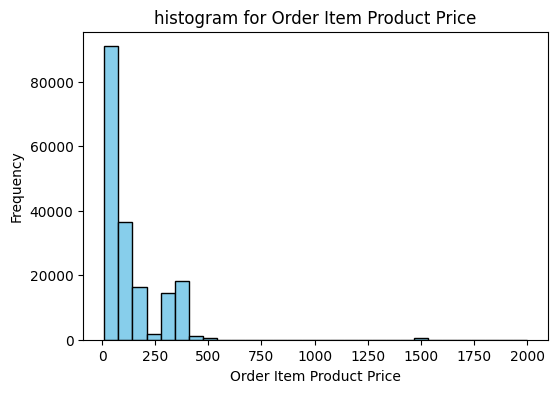

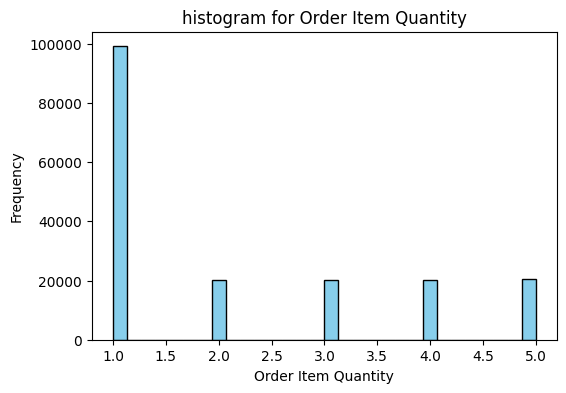

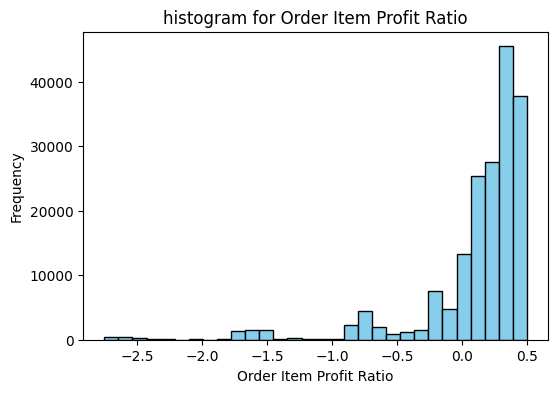

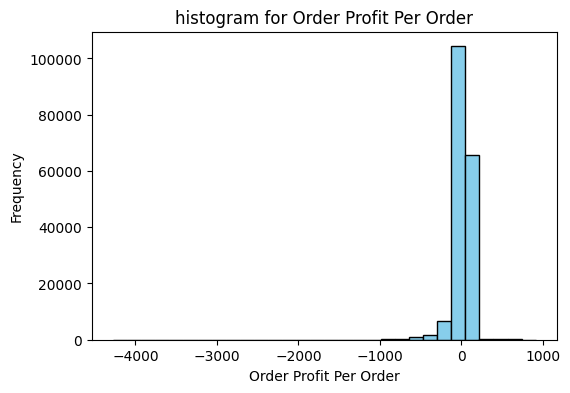

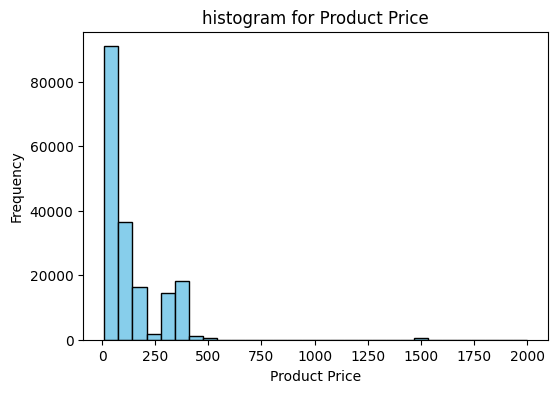

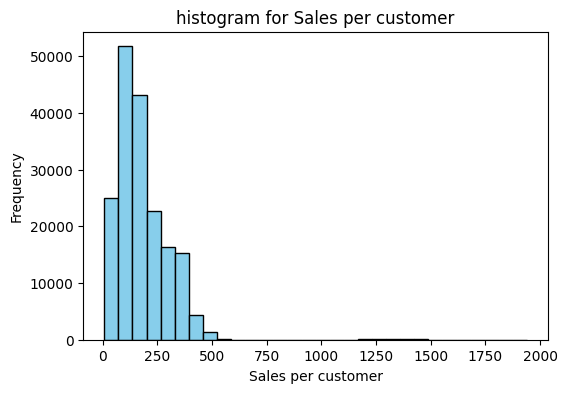

In [21]:
import matplotlib.pyplot as plt

for col in numeric_COLUMN : 
    plt.figure(figsize=(6,4))
    plt.hist(spark_to_pd[col].dropna(), bins = 30 , color='skyblue', edgecolor='black')
    plt.xlabel(col)
    plt.title(f"histogram for {col}")
    plt.ylabel("Frequency")
    plt.show()

In [22]:
df.show()

[Stage 106:==>                                                    (1 + 21) / 22]

+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+----------------+-------------+----------------+----------------+--------------+---------------+-----------+------------+------------+-------------+--------------+-----------------------+-------------------+------------------------+------------------------+-----------------------+-------------------+-----------+----------------+----------------------+---------------+--------------------+-------------+--------------------------+--------------+
|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|  Delivery Status|Late_delivery_risk|   Category Name|Customer City|Customer Country|Customer Segment|Customer State|Department Name|   Latitude|   Longitude|      Market|   Order City| Order Country|order date (DateOrders)|Order Item Discount|Order Item Discount Rate|Order Item Product Price|Order Item Profit Ratio|Order Item Q

In [23]:
from pyspark.sql.types import NumericType

numeric_cols = [c for c in df.schema.names if isinstance(df.schema[c].dataType, NumericType)]
numeric_cols


['Days for shipping (real)',
 'Days for shipment (scheduled)',
 'Benefit per order',
 'Sales per customer',
 'Late_delivery_risk',
 'Latitude',
 'Longitude',
 'Order Item Discount',
 'Order Item Discount Rate',
 'Order Item Product Price',
 'Order Item Profit Ratio',
 'Order Item Quantity',
 'Sales',
 'Order Item Total',
 'Order Profit Per Order',
 'Product Price']

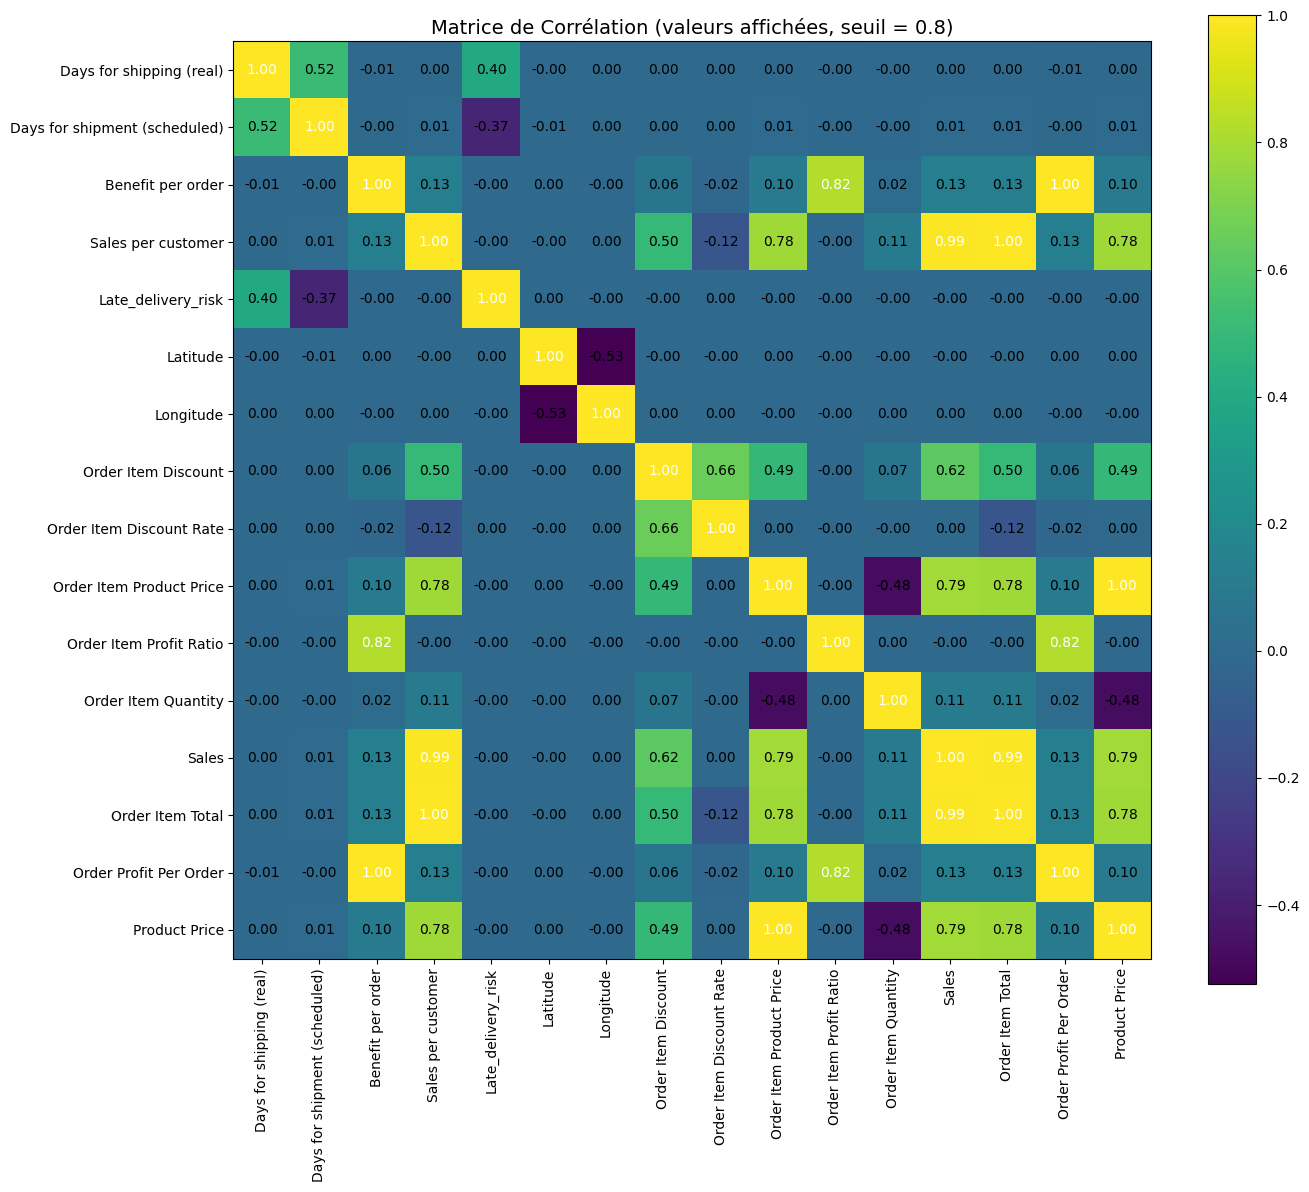

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# 2. Conversion Spark -> Pandas
pdf = df.select(numeric_cols).toPandas()

# 3. Matrice de corrélation
corr = pdf.corr()

# 4. Création de l’image (heatmap annotée)
plt.figure(figsize=(14, 12))
plt.imshow(corr, interpolation="nearest")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()

# 5. Annotation des valeurs + mise en évidence du seuil 0.8
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        value = corr.iloc[i, j]
        color = "white" if abs(value) > 0.8 else "black"  # seuil 0.8 mis en blanc
        plt.text(j, i, f"{value:.2f}", ha='center', va='center', color=color)

plt.title("Matrice de Corrélation (valeurs affichées, seuil = 0.8)", fontsize=14)
plt.tight_layout()
plt.show()

In [25]:
import pyspark.sql.functions as F

variance_df = df.select([F.variance(c).alias(f"variance_{c}") for c in numeric_cols])
variance_df.show(truncate=False)


[Stage 112:==>                                                    (1 + 21) / 22]

+---------------------------------+--------------------------------------+--------------------------+---------------------------+---------------------------+-----------------+------------------+----------------------------+---------------------------------+---------------------------------+--------------------------------+----------------------------+-----------------+-------------------------+-------------------------------+----------------------+
|variance_Days for shipping (real)|variance_Days for shipment (scheduled)|variance_Benefit per order|variance_Sales per customer|variance_Late_delivery_risk|variance_Latitude|variance_Longitude|variance_Order Item Discount|variance_Order Item Discount Rate|variance_Order Item Product Price|variance_Order Item Profit Ratio|variance_Order Item Quantity|variance_Sales   |variance_Order Item Total|variance_Order Profit Per Order|variance_Product Price|
+---------------------------------+--------------------------------------+--------------------

In [26]:
from pyspark.sql.types import StringType

categorical_cols = [c for c in df.schema.names if isinstance(df.schema[c].dataType, StringType)]
categorical_cols


['Delivery Status',
 'Category Name',
 'Customer City',
 'Customer Country',
 'Customer Segment',
 'Customer State',
 'Department Name',
 'Market',
 'Order City',
 'Order Country',
 'order date (DateOrders)',
 'Order Region',
 'Order State',
 'shipping date (DateOrders)',
 'Shipping Mode']

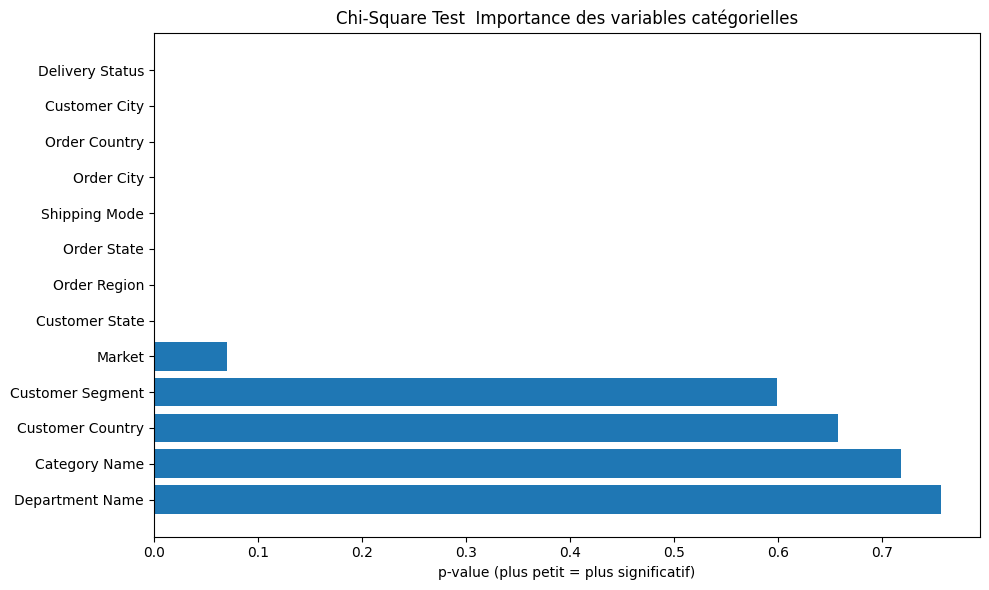

In [27]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import ChiSquareTest
import pandas as pd
import matplotlib.pyplot as plt

# Colonnes catégorielles
categorical_cols = [
    'Delivery Status',
    'Category Name',
    'Customer City',
    'Customer Country',
    'Customer Segment',
    'Customer State',
    'Department Name',
    'Market',
    'Order City',
    'Order Country',
    'Order Region',
    'Order State',
    'Shipping Mode'
]

# 1. Supprimer les index déjà créés
for col in categorical_cols:
    if col + "_index" in df.columns:
        df = df.drop(col + "_index")

# 2. Indexage
for col in categorical_cols:
    df = StringIndexer(
        inputCol=col,
        outputCol=col + "_index",
        handleInvalid="skip"
    ).fit(df).transform(df)

indexed_cols = [c + "_index" for c in categorical_cols]

# 3. Assemble
assembler = VectorAssembler(inputCols=indexed_cols, outputCol="features")
df_chi = assembler.transform(df).select("Late_delivery_risk", "features")

# 4. Chi2
chi = ChiSquareTest.test(df_chi, "features", "Late_delivery_risk").head()

chi_df = pd.DataFrame({
    "feature": categorical_cols,
    "p_value": chi.pValues,
    "statistic": chi.statistics
})

chi_df = chi_df.sort_values("p_value")

# 5. Image
plt.figure(figsize=(10, 6))
plt.barh(chi_df["feature"], chi_df["p_value"])
plt.xlabel("p-value (plus petit = plus significatif)")
plt.title("Chi-Square Test  Importance des variables catégorielles")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [28]:
df.filter(df["Delivery Status"] == "Shipping canceled").show()


[Stage 206:==>                                                    (1 + 21) / 22]

+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+----------------+-------------+----------------+----------------+--------------+---------------+-----------+------------+------------+-------------+------------------+-----------------------+-------------------+------------------------+------------------------+-----------------------+-------------------+-----------+----------------+----------------------+---------------+--------------------+-------------+--------------------------+--------------+---------------------+-------------------+-------------------+----------------------+----------------------+--------------------+---------------------+------------+----------------+-------------------+------------------+-----------------+-------------------+
|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|  Delivery Status|Late_delivery_risk|   Category Name|Customer City|

In [29]:
df2 = df.filter(df["Delivery Status"] != "Canceled")


In [30]:
df2.filter(df2["Delivery Status"] == "Delivery Status").show()

+------------------------+-----------------------------+-----------------+------------------+---------------+------------------+-------------+-------------+----------------+----------------+--------------+---------------+--------+---------+------+----------+-------------+-----------------------+-------------------+------------------------+------------------------+-----------------------+-------------------+-----+----------------+----------------------+------------+-----------+-------------+--------------------------+-------------+---------------------+-------------------+-------------------+----------------------+----------------------+--------------------+---------------------+------------+----------------+-------------------+------------------+-----------------+-------------------+
|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|Delivery Status|Late_delivery_risk|Category Name|Customer City|Customer Country|Customer Segment|Customer State|

In [31]:
columnsF = [
    "Late_delivery_risk",
    "Days for shipment (scheduled)",
    "Order Region",
    "Sales",
    "Order Item Quantity",
    "Order Item Profit Ratio",
    "Order City",
    "Latitude",
    "Longitude",
    "Customer Segment",
    "Category Name",
    "Sales per customer"
]

In [32]:
dff=df2.select(columnsF)

In [33]:
dff.show()

[Stage 216:============>                                          (5 + 17) / 22]

+------------------+-----------------------------+---------------+-----------+-------------------+-----------------------+-------------+-----------+------------+----------------+----------------+------------------+
|Late_delivery_risk|Days for shipment (scheduled)|   Order Region|      Sales|Order Item Quantity|Order Item Profit Ratio|   Order City|   Latitude|   Longitude|Customer Segment|   Category Name|Sales per customer|
+------------------+-----------------------------+---------------+-----------+-------------------+-----------------------+-------------+-----------+------------+----------------+----------------+------------------+
|                 1|                            2|Northern Europe|239.9600067|                  4|            0.289999992|   Eastbourne|18.02538109|-66.61508179|     Home Office|          Cleats|       201.5700073|
|                 0|                            4|Southern Europe|399.9599915|                  4|            0.469999999|        Turin|36.9

In [34]:
pdf = dff.toPandas()


In [35]:
pdf.to_csv("../data/Processed/cleanData.csv", index=False)


<bound method SparkSession.stop of <pyspark.sql.session.SparkSession object at 0x7fc3b50ef010>>